In [3]:
# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected import statement for Prophet
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

def mean_absolute_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/ y_true)) *100

pjme = pd.read_csv('/content/mock_kaggle.csv', index_col = [0], parse_dates = [0])
pjme.head()
# %% [markdown]
# Data
#
# %%

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


Data

In [4]:
pjme = pd.read_csv('/content/mock_kaggle.csv', index_col = [0], parse_dates = [0])
pjme.head()

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


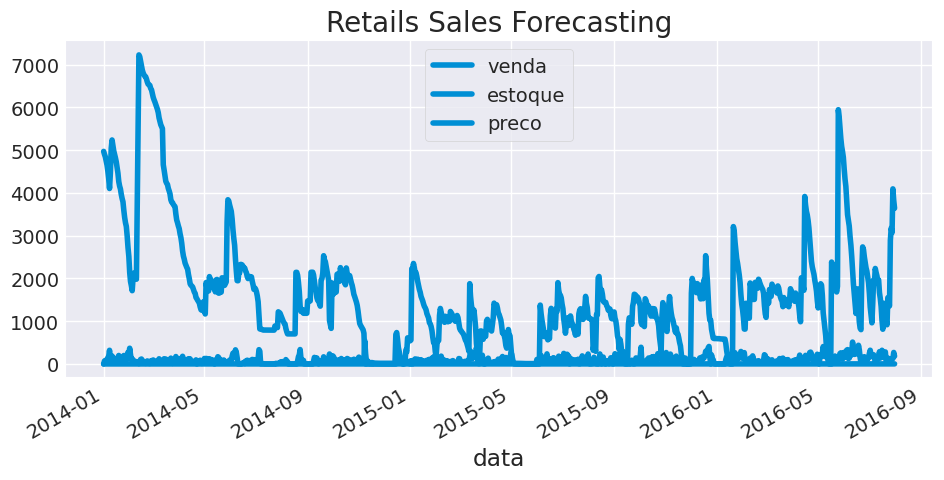

In [7]:
color_pal = sns.color_palette()
pjme.plot(figsize = (10,5), ms = 1, color = color_pal[0], title = "Retails Sales Forecasting")
plt.show()

#Time Series Features

In [19]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories = ['Monday','Teusday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered = True)

def create_features(df, label = None):

  """
  creates time series features from datatime index
  """
  df = df.copy()
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['weekday'] = df['date'].dt.day_name()
  df['weekday'] = df['weekday'].astype(cat_type)
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week
  df['date_offset'] = (df.date.dt.month* 100 + df.date.dt.day-320)%1300

  df['season'] = pd.cut(df['date_offset'], bins = [0,300,602,900,1300],
                        labels = ['Spring','Summer','Fall','Winter'])

  X = df[['hour','dayofweek','weekday','quarter','month','year',
          'dayofyear','dayofmonth','weekofyear','season']]

  if label:
    y = df[label]
    return X, y
  return X


X, y = create_features(pjme, label = 'venda')
features_and_target = pd.concat([X,y], axis = 1)


Index(['venda', 'estoque', 'preco'], dtype='object')


In [20]:
features_and_target.head()

,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,venda
data,,,,,,,,,,,
2014-01-01,0,2,Wednesday,1,1,2014,1,1,1,Winter,0
2014-01-02,0,3,Thursday,1,1,2014,2,2,1,Winter,70
2014-01-03,0,4,Friday,1,1,2014,3,3,1,Winter,59
2014-01-04,0,5,Saturday,1,1,2014,4,4,1,Winter,93
2014-01-05,0,6,Sunday,1,1,2014,5,5,1,Winter,96


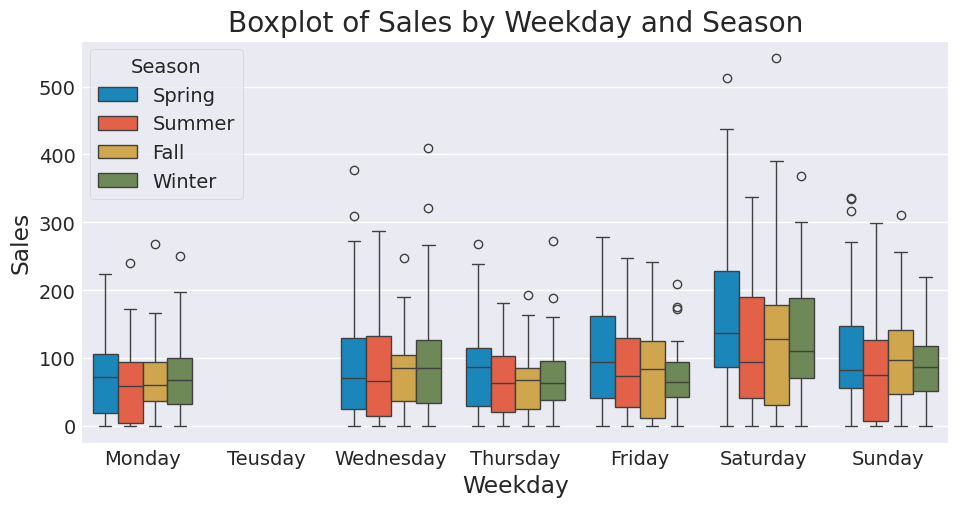

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(data = features_and_target.dropna(), x = 'weekday', y = 'venda',
            hue = 'season', ax = ax,
            linewidth = 1)
ax.set_title('Boxplot of Sales by Weekday and Season')
ax.set_xlabel('Weekday')
ax.set_ylabel('Sales')
ax.legend(title = 'Season')
plt.show()

# Train/ Test Split

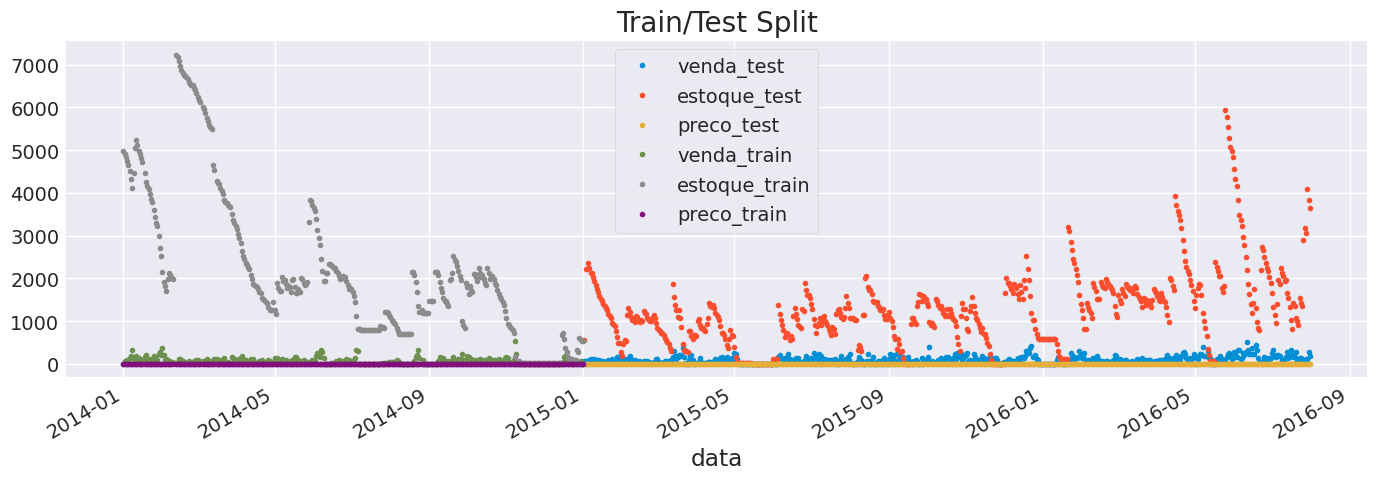

In [27]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

#Plot train and test so you can see where we have the split
pjme_test \
  .rename(columns = {'venda':'venda_test'}) \
  .join(pjme_train.rename(columns = {'venda':'venda_train'}),
        how = 'outer', lsuffix = '_test', rsuffix = '_train') \
  .plot(figsize = (15,5), title = 'Train/Test Split', style = '.')

plt.show()

# Simple Prophet Model

In [28]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(columns = {'data':'ds', 'venda':'y'})

In [29]:
pjme_train_prophet.head()

,ds,y,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [30]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzgfibsw/nk8_zww9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzgfibsw/_jupwzz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54916', 'data', 'file=/tmp/tmpdzgfibsw/nk8_zww9.json', 'init=/tmp/tmpdzgfibsw/_jupwzz5.json', 'output', 'file=/tmp/tmpdzgfibsw/prophet_modelckwjchfe/prophet_model-20250715095407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:54:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:54:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 722 ms, sys: 62.9 ms, total: 785 ms
Wall time: 994 ms


In [48]:
# Predict on test set with model
pjme_train_prophet = pjme_train.reset_index().rename(columns = {'data':'ds', 'venda':'y'})
pjme_test_fcst = model.predict(pjme_test_prophet)

In [49]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,41.541548,-41.343391,121.002142,41.541548,41.541548,-2.497732,-2.497732,-2.497732,-2.497732,-2.497732,-2.497732,0.0,0.0,0.0,39.043816
1,2015-01-03,41.384587,5.657239,168.034600,41.384587,41.384587,44.082928,44.082928,44.082928,44.082928,44.082928,44.082928,0.0,0.0,0.0,85.467515
2,2015-01-04,41.227626,-36.027255,131.635809,41.227626,41.227626,9.956704,9.956704,9.956704,9.956704,9.956704,9.956704,0.0,0.0,0.0,51.184331
3,2015-01-05,41.070665,-59.082797,103.635383,41.070634,41.070700,-18.067184,-18.067184,-18.067184,-18.067184,-18.067184,-18.067184,0.0,0.0,0.0,23.003481
4,2015-01-06,40.913704,-65.124881,104.036719,40.913611,40.913801,-21.561516,-21.561516,-21.561516,-21.561516,-21.561516,-21.561516,0.0,0.0,0.0,19.352189


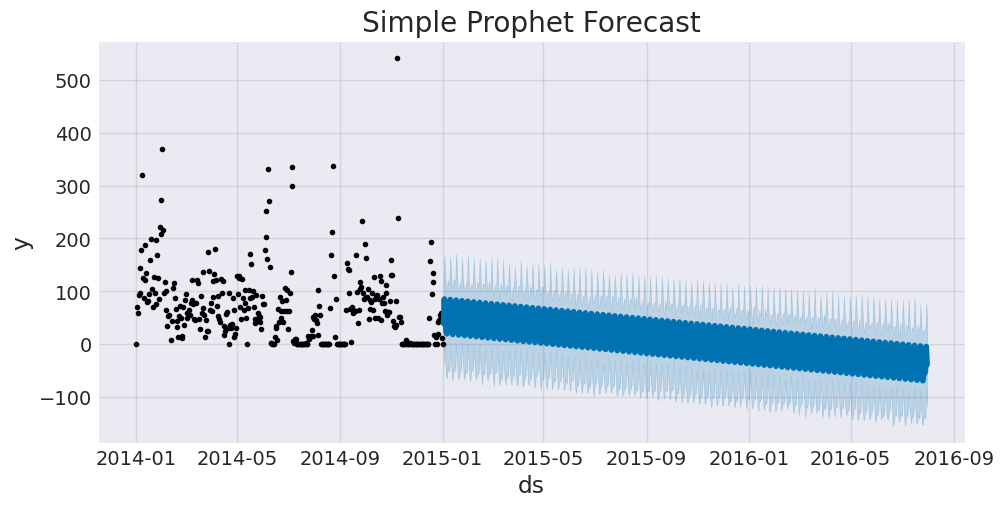

In [50]:
fig, ax = plt.subplots(figsize = (10,5))
fig = model.plot(pjme_test_fcst,ax = ax)
ax.set_title('Simple Prophet Forecast')
plt.show()

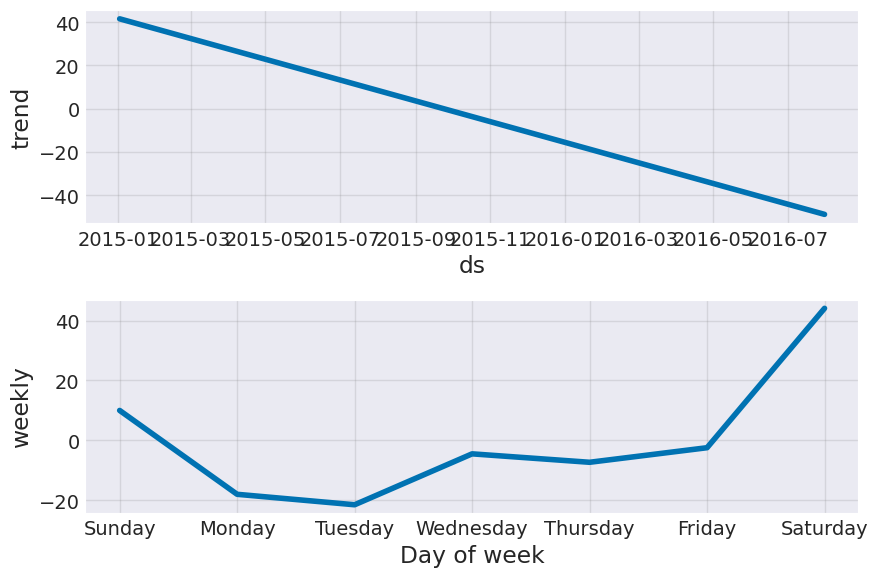

In [51]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

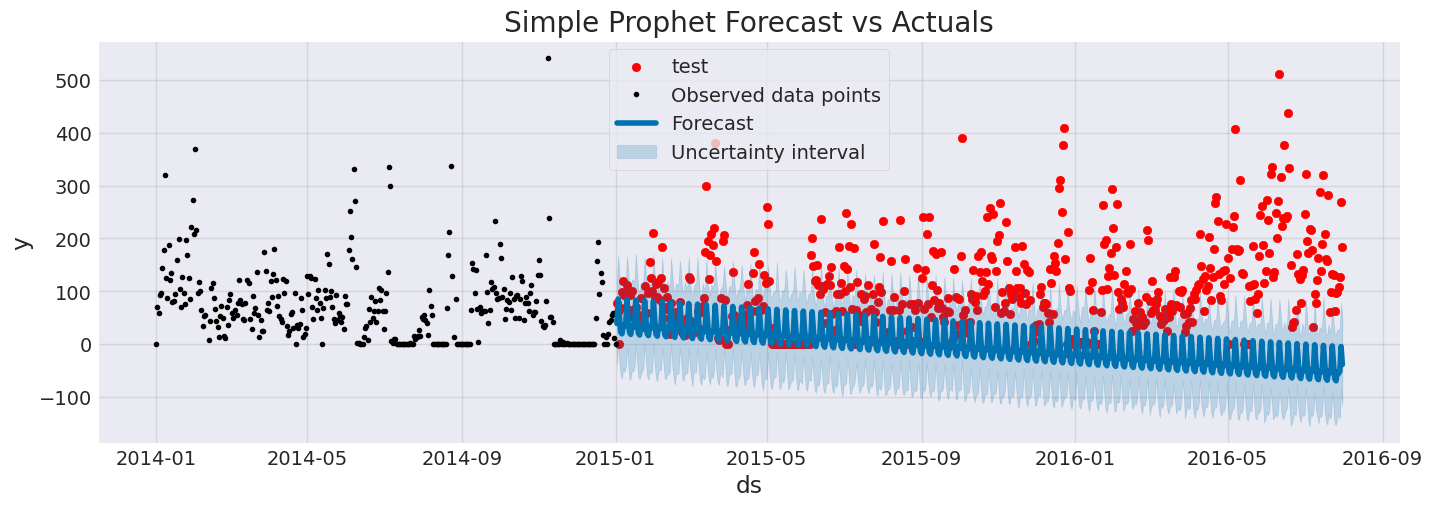

In [52]:
# plot the forecast with the actuals
f, ax = plt.subplots(figsize = (15,5))
ax.scatter(pjme_test.index, pjme_test['venda'], label = 'test', color = 'r')
fig = model.plot(pjme_test_fcst, ax = ax)
ax.set_title('Simple Prophet Forecast vs Actuals')
ax.legend()
plt.show()

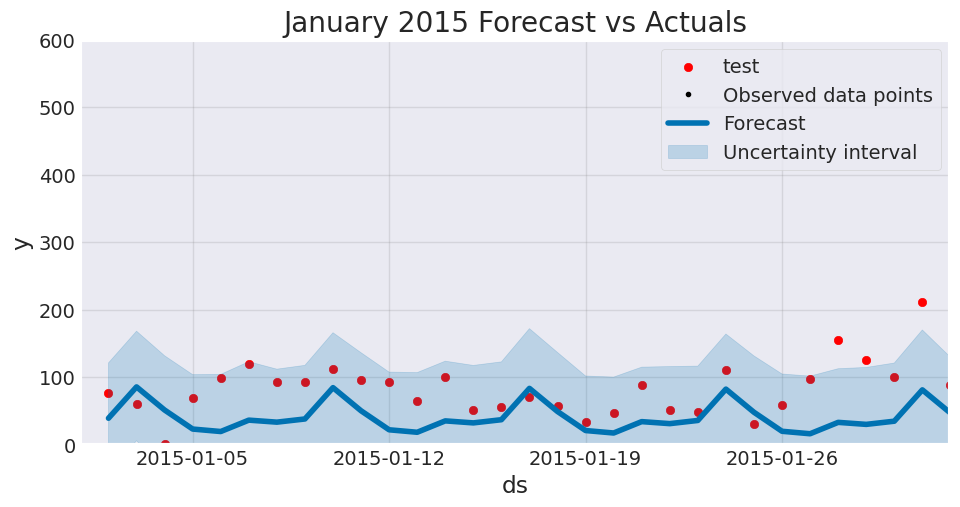

In [56]:
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(pjme_test.index, pjme_test['venda'], label = 'test', color = 'r')
fig = model.plot(pjme_test_fcst, ax = ax)

# Convert date strings to datetime objects before setting bounds
import pandas as pd # Ensure pandas is imported for to_datetime
ax.set_xbound(lower = pd.to_datetime('01-01-2015'), upper = pd.to_datetime('02-01-2015'))
ax.set_ylim(0,600)
ax.set_title('January 2015 Forecast vs Actuals')
ax.legend()
plt.show()


# Evaluate the model with Error Metrics

In [57]:

# Now calculate the error metric
np.sqrt(mean_squared_error(y_true = pjme_test['venda'],y_pred = pjme_test_fcst['yhat']))

np.float64(141.13696895207477)

In [62]:
mean_absolute_error(y_true = pjme_test['venda'], y_pred = pjme_test_fcst['yhat'])

np.float64(160.74391060914616)

In [59]:
def mean_absolute_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  # Create a mask to exclude zero values from y_true
  non_zero_mask = y_true != 0
  # Calculate MAPE only for non-zero actual values
  mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask])/ y_true[non_zero_mask])) *100
  return mape

# Now calculate the error metric using the modified function
mean_absolute_error(y_true = pjme_test['venda'], y_pred = pjme_test_fcst['yhat'])


np.float64(160.74391060914616)

# Predict into the Future

In [65]:
future = model.make_future_dataframe(periods=365*24, freq = 'h', include_history= False)
forecast = model.predict(future)

In [66]:
forecast[['yhat']].head()

,yhat
0,33.383521
1,32.449559
2,31.544325
3,30.682241
4,29.877648


# Sales Forecast

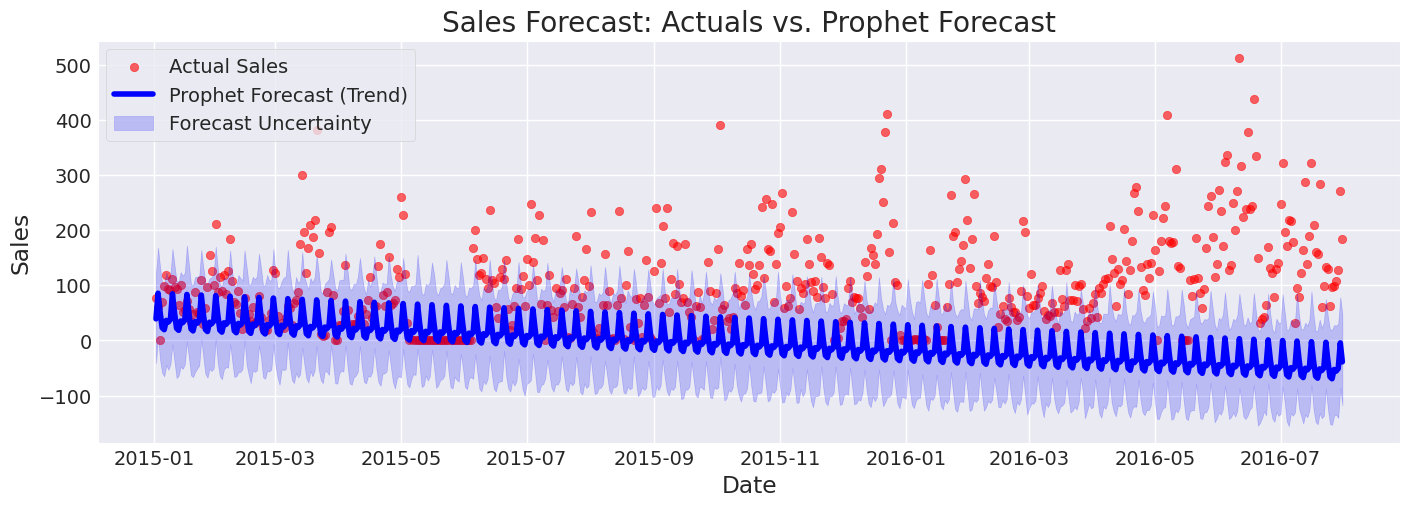

In [67]:
# Example of highlighting the trend line:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['venda'], label='Actual Sales', color='r', alpha=0.6)
ax.plot(pjme_test_fcst['ds'], pjme_test_fcst['yhat'], label='Prophet Forecast (Trend)', color='blue')
ax.fill_between(pjme_test_fcst['ds'], pjme_test_fcst['yhat_lower'], pjme_test_fcst['yhat_upper'], color='blue', alpha=0.2, label='Forecast Uncertainty')
ax.set_title('Sales Forecast: Actuals vs. Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.show()

# Monthly and Yearly comparisons

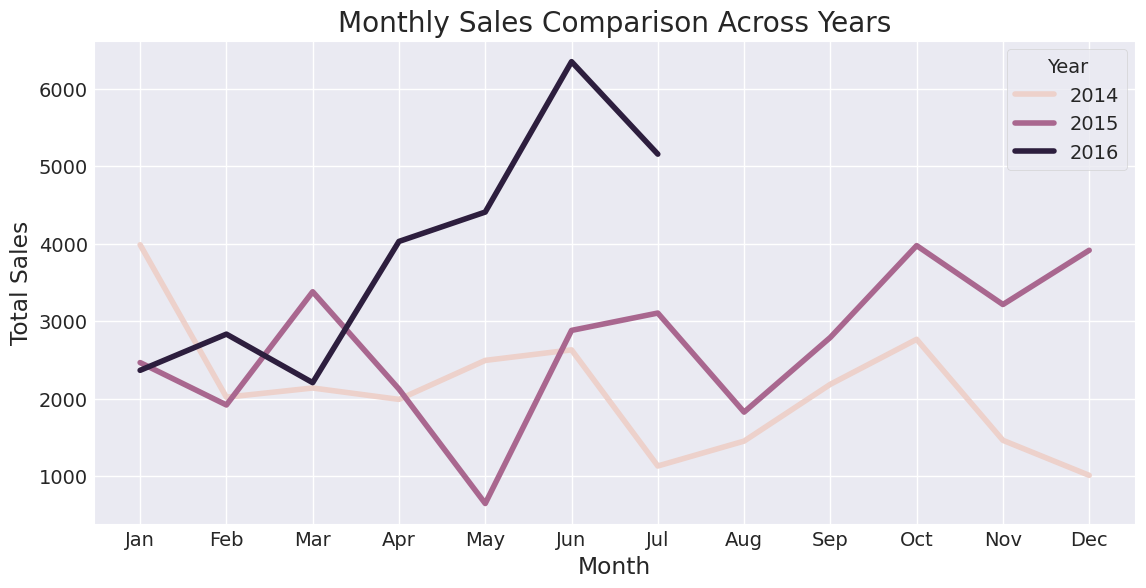

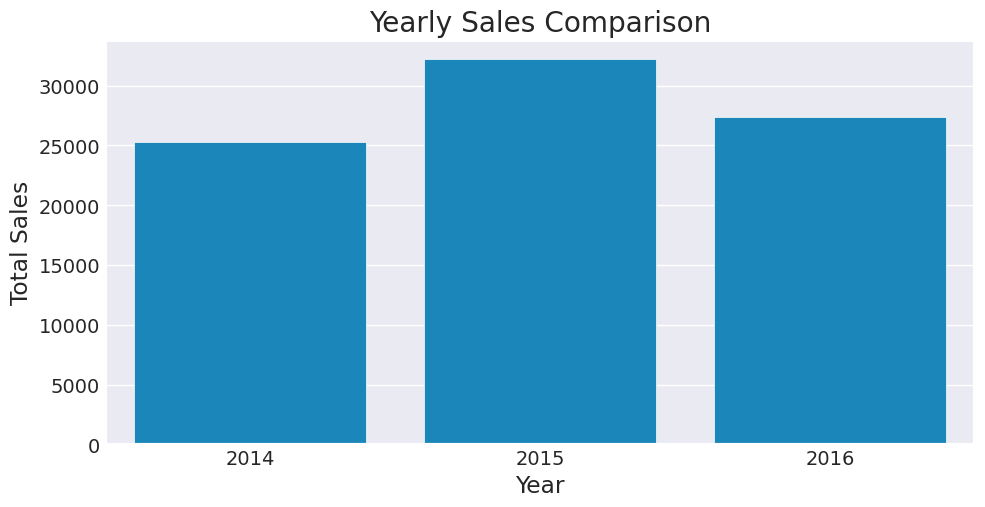

In [68]:
# Aggregate by month and year for actual data
monthly_sales = features_and_target.groupby(['year', 'month'])['venda'].sum().reset_index()

# You would need to generate forecasts for historical periods to compare
# forecast with actuals monthly/yearly. This involves running Prophet
# on your training data or a rolling window.

# For now, let's visualize the actual monthly sales
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='month', y='venda', hue='year')
plt.title('Monthly Sales Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

# You can do a similar aggregation and visualization for yearly sales.
yearly_sales = features_and_target.groupby('year')['venda'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=yearly_sales, x='year', y='venda')
plt.title('Yearly Sales Comparison')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

# Highlight top sellling items & low seasons

In [69]:


# Find top-selling items
if 'item' in pjme.columns:
    item_sales = pjme.groupby('item')['venda'].sum().sort_values(ascending=False)
    print("Top 10 Selling Items:")
    print(item_sales.head(10))

# Identify low seasons from the boxplot you already created

# calculate average sales by season:
seasonal_avg_sales = features_and_target.groupby('season')['venda'].mean().sort_values()
print("\nAverage Sales by Season:")
print(seasonal_avg_sales)


Average Sales by Season:
season
Summer     83.048246
Fall       87.589888
Winter     88.091270
Spring    100.322464
Name: venda, dtype: float64


# Insight cards for decision making

In [70]:
# Example insight card:
print("--- Insight Card ---")
print(f"Overall Average Daily Sales: {pjme['venda'].mean():.2f}")
print(f"RMSE of Prophet Model on Test Set: {np.sqrt(mean_squared_error(y_true = pjme_test['venda'],y_pred = pjme_test_fcst['yhat'])):.2f}")
print(f"MAPE of Prophet Model on Test Set: {mean_absolute_error(y_true = pjme_test['venda'], y_pred = pjme_test_fcst['yhat']):.2f}%")
# Add insights about top-selling items, low seasons, trends, etc.
print("Observation: Sales tend to be lower during the Winter season.")
print("--- End Insight Card ---")


--- Insight Card ---
Overall Average Daily Sales: 90.53
RMSE of Prophet Model on Test Set: 141.14
MAPE of Prophet Model on Test Set: 160.74%
Observation: Sales tend to be lower during the Winter season.
--- End Insight Card ---
